<a href="https://colab.research.google.com/github/shivendr7/SatGAN/blob/master/EEGAN_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This is the close implementation of Edge Enhanced GAN for image sensing and superresolution published in 2019.

After the introduction of GAN By Goodfellow in 2016, it has been a hot topic of interest and deep learning based methods have shown remarkable results in image superresolution.

This work was focused to successfully recover high-frequency edge details by the inetresting adversarial concept of GANs.

> "In this paper, we propose a generative adversarial network (GAN)-based edge-enhancement
network (EEGAN) for robust satellite image SR reconstruction
along with the adversarial learning strategy that is insensitive to
noise."

To the [original paper..](https://www.researchgate.net/profile/Kui-Jiang-3/publication/332089421_Edge-Enhanced_GAN_for_Remote_Sensing_Image_Superresolution/links/5ca2042e45851506d7391348/Edge-Enhanced-GAN-for-Remote-Sensing-Image-Superresolution.pdf)



> In EEGAN, the generator consists of two subnetworks: 
**ultradense subnetwork (UDSN)**
and 
**edge-enhancement subnetwork (EESN)**. UDSN is used
to reconstruct an intermediate SR result that looks sharp but
takes noise-contaminated edges. Thus, EESN is specially constructed to enforce the edges by learning a noise mask


For the implementation of the model we used the keras, and tensorflow APIs and numpy for tensor calculations

Please run the following shell

In [1]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Concatenate, Lambda, Subtract, Add, Activation, Reshape, Multiply, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf
from keras.losses import MeanSquaredError 
import keras.backend as K
import numpy as np

#UDSN

> "UDSN consists of several **dense blocks** but is used for feature
extraction and fusion in a 2-D topology. In the block, each
convolutional layer has access to all the subsequent layers both
in horizontal and vertical dimensions. In this way, a large number of feature maps are estimated from an LR input through
UDSN, followed by a **subpixel convolution layer** [[31]](https://arxiv.org/pdf/1609.05158.pdf) to reconstruct an intermediate SR result(Ibase)."



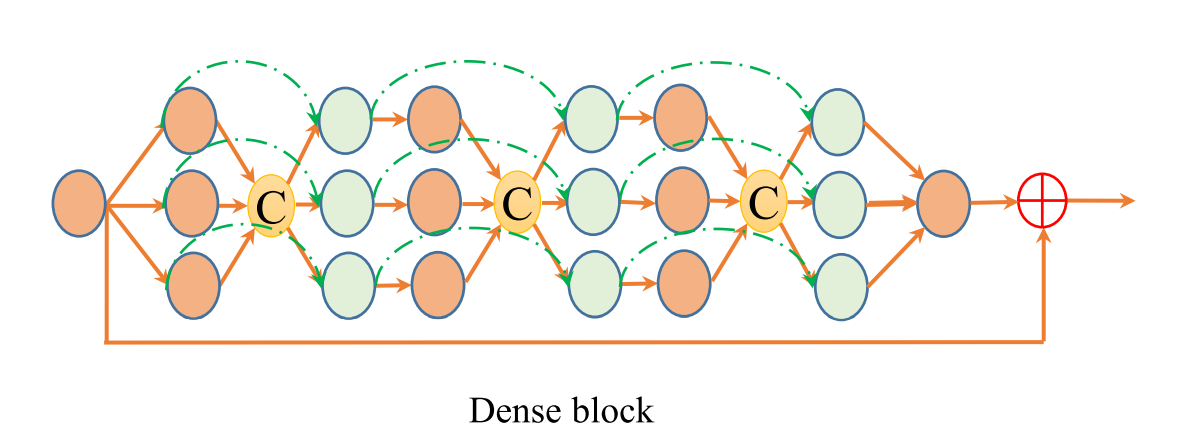

The circles represent conv layers where the blue ones are 64 batch 1x1 filters and the red ones are 64 batch 3x3 filters. The C circle is the Concatenation layer and all the arrows indicate skip connections

Following is the code for a dense block please do run the shell and the one after it to see how a dense block looks


In [2]:
def dense_block(in_layer):
  init=RandomNormal(stddev=0.2)  #an initializer for the kernels as instructed in Soumith Chintana's GAN hacks
  conv1=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(in_layer) #red circle 1
  conv11=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(conv1)   #red circle 2
  conv12=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(conv1)   #red circle 3 
  conv13=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(conv1)   #red circle 4
  concat1=Concatenate()([conv11, conv12, conv13])   #C circle 1
  conv201=Concatenate()([concat1, conv11])          #skip connection to red circle 2
  conv202=Concatenate()([concat1, conv12])          #skip connection to red circle 3
  conv203=Concatenate()([concat1, conv13])          #skip connection to red circle 4
  conv21i=Conv2D(filters=64, kernel_size=(1,1), padding='same', kernel_initializer=init)(conv201)  #blue circle 1
  conv22i=Conv2D(filters=64, kernel_size=(1,1), padding='same', kernel_initializer=init)(conv202)  #blue circle 2
  conv23i=Conv2D(filters=64, kernel_size=(1,1), padding='same', kernel_initializer=init)(conv203)  #blue circle 3
  conv21=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(conv21i)   #red circle 5
  conv22=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(conv22i)   #red circle 6 
  conv23=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(conv23i)   #red circle 7
  concat2=Concatenate()([conv21, conv22, conv23])   #C circle 2
  conv301=Concatenate()([concat2, conv21i])         #skip connection 
  conv302=Concatenate()([concat2, conv22i])         #skip connection
  conv303=Concatenate()([concat2, conv23i])         #skip connection
  conv31i=Conv2D(filters=64, kernel_size=(1,1), padding='same', kernel_initializer=init)(conv301)
  conv32i=Conv2D(filters=64, kernel_size=(1,1), padding='same', kernel_initializer=init)(conv302)
  conv33i=Conv2D(filters=64, kernel_size=(1,1), padding='same', kernel_initializer=init)(conv303)
  conv31=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(conv31i)
  conv32=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(conv32i)
  conv33=Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer=init)(conv33i)
  concat3=Concatenate()([conv31, conv32, conv33])
  conv401=Concatenate()([concat3, conv31i])
  conv402=Concatenate()([concat3, conv32i])
  conv403=Concatenate()([concat3, conv33i])
  conv41i=Conv2D(filters=64, kernel_size=(1,1), padding='same', kernel_initializer=init)(conv401)
  conv42i=Conv2D(filters=64, kernel_size=(1,1), padding='same', kernel_initializer=init)(conv402)
  conv43i=Conv2D(filters=64, kernel_size=(1,1), padding='same', kernel_initializer=init)(conv403)
  concat4=Concatenate()([conv41i, conv42i, conv43i])
  out_layer=Concatenate()([concat4, conv1])
  return out_layer

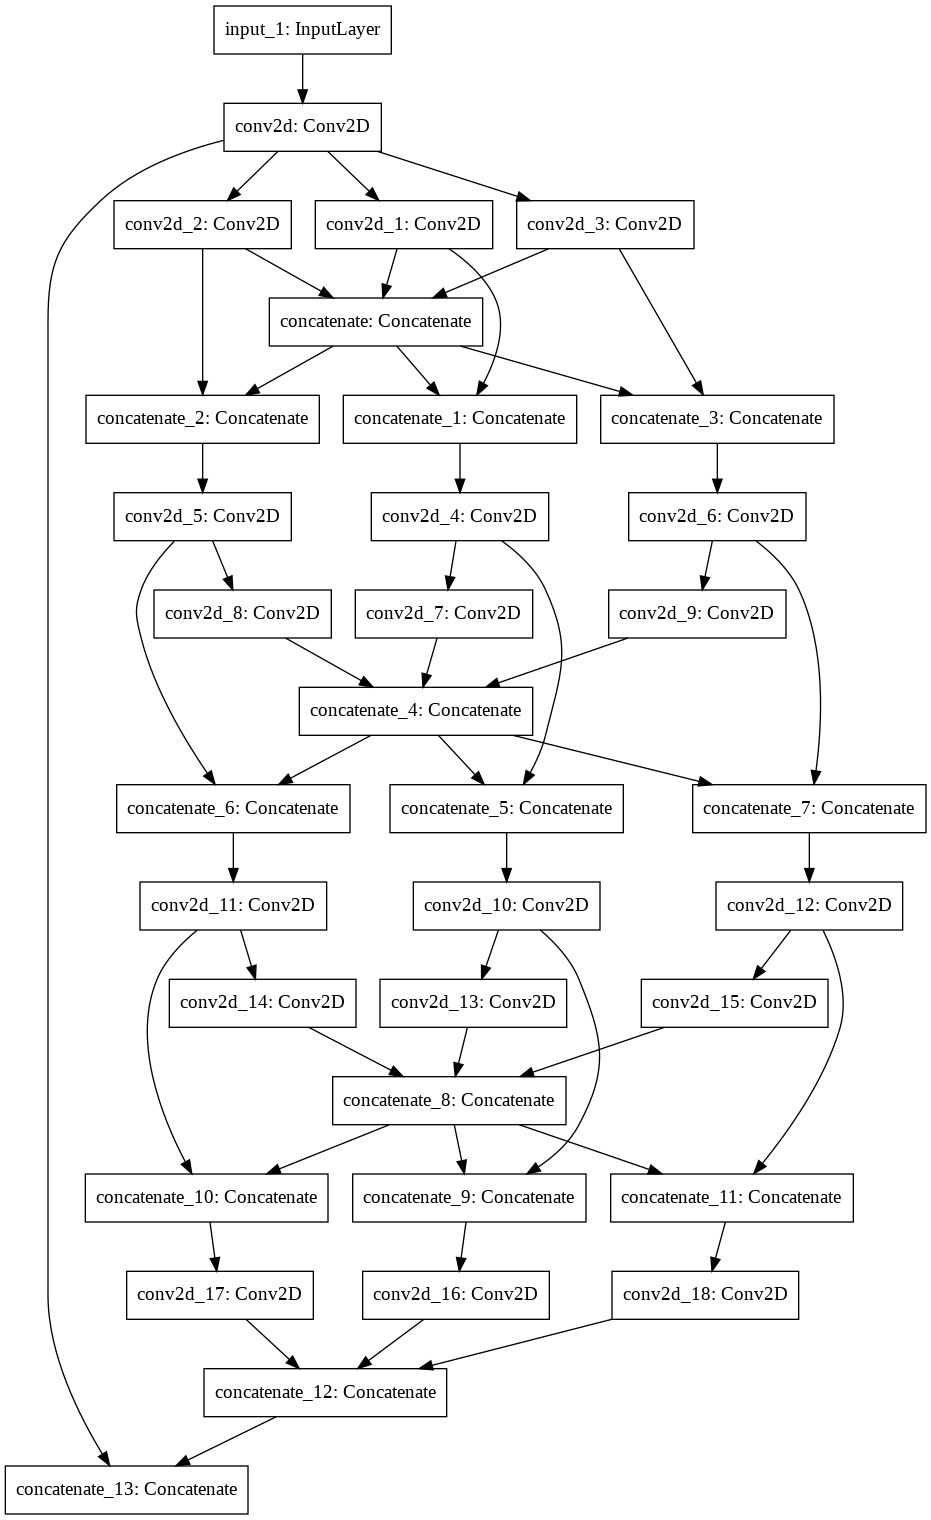

In [3]:
inp=Input(shape=(28,28,1))
m=Model(inputs=inp, outputs=dense_block(inp)) #creating a model with single dense block
plot_model(m)  #plot the model

###Subpixel Conv
Our paper has only the annotation [31] for this new paper where it was demonstrated how subpixel convolution has edge over advantages over inetrpolated convolution or fractional convolution also called deconvolution

Building a subpixel conv layer in keras was definitely not easy. We are fortunate to get this API. Please do run the next shell.

In [4]:
def SubpixelConv2D(input_shape, scale=4):  
  #scale 4 says tensor of shape (batch, length, width, depth*4) would be transformed to shape (batch, length*2, width*2, depth)

    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')

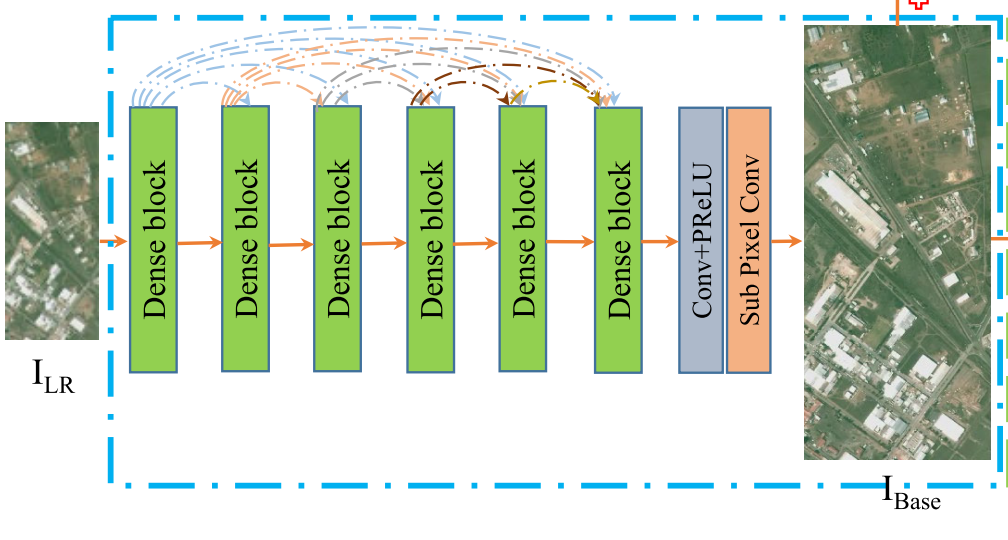

finally writing UDSN, please do run the next shell

In [5]:
def build_udsn(image_shape):
  inp=Input(shape=image_shape)
  db1=dense_block(inp)  #creating dense_blocks
  con=Concatenate()([db1, db1])  #concatenating subsequent dense blocks for skip connections
  db2=dense_block(con)
  con=Concatenate()([db1, db2, db2])
  db3=dense_block(con)
  con=Concatenate()([db1, db2, db3, db3])
  db4=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db4])
  db5=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db5, db5])
  db6=dense_block(con)
  LR=Conv2D(filters=12, kernel_size=(3,3), padding='same')(db6)   #final feature-extracted tensor of shape (None, l, w, h*4(=12))
  LR=LeakyReLU(alpha=0.2)(LR)
  Ibase=SubpixelConv2D(LR.shape, scale=2)(LR)   #final generated intermediate HR result (upscaled by scale factor of 2)
  model=Model(inputs=inp, outputs=Ibase)   #creating a model of these layers
  return model

To view the demo of subpixel convolution please open in new tab a [demo of Real-Time Single Image and Video Super-Resolution Using an Efficient
Sub-Pixel Convolutional Neural Network](https://colab.research.google.com/drive/1MRGk0le3YWIk0tWbx4BiN52UYKvAV28I?usp=sharing)

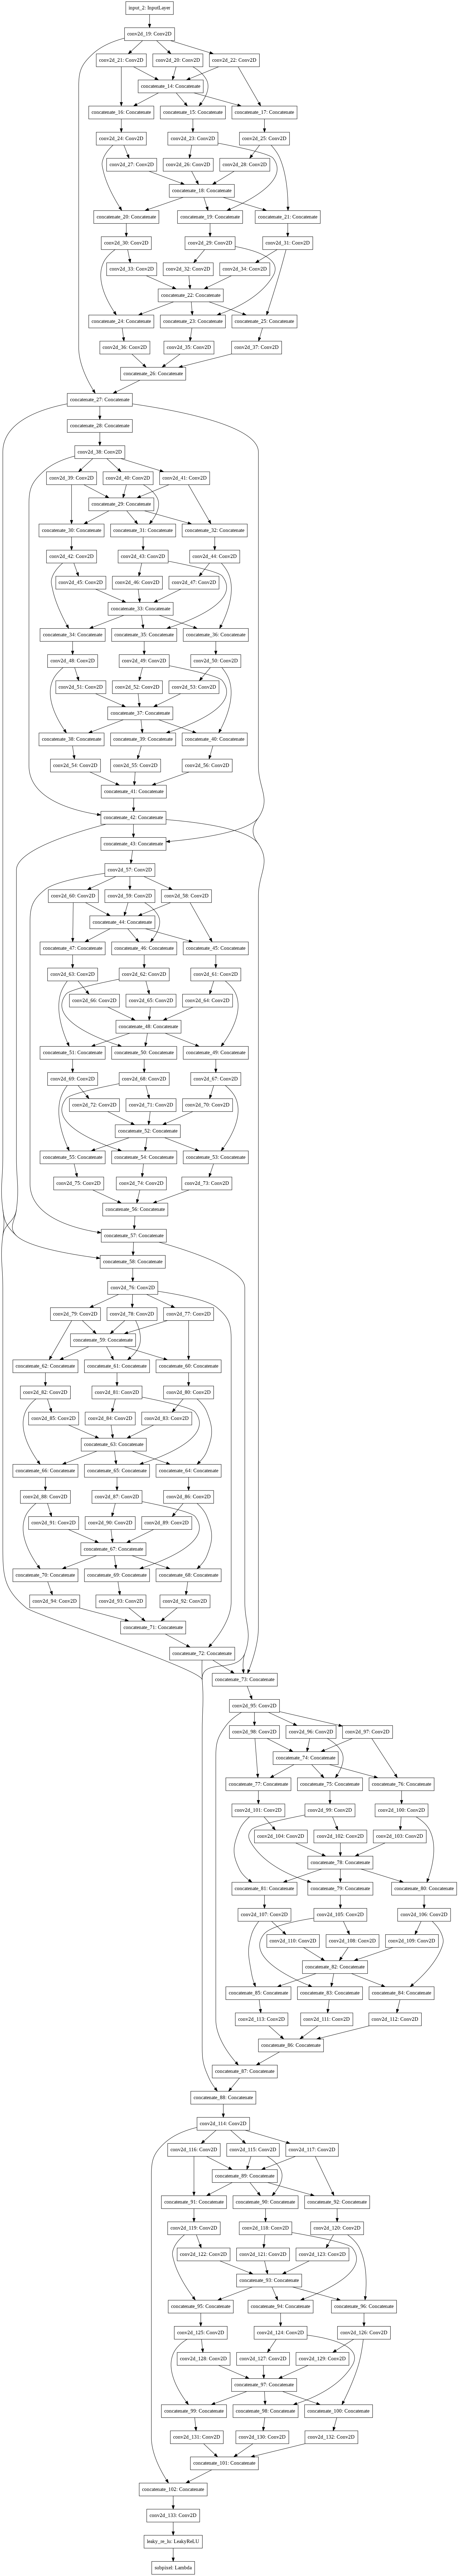

In [6]:
udsn=build_udsn(image_shape=(128,128,3)) #defining udsn
plot_model(udsn)

In [7]:
udsn.summary()  #run to look at udsn structure

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_19[0][0]                  
____________________________________________________________________________________________

#EESN
EESN can be roughly divided
into five parts: edge extraction, low-dimensional projection,
edge enhancement, mask processing, and high-dimensional
reconstruction

First, we introduce the Laplacian operator [32]
to extract image edges

In [8]:
def laplacian(shape, dtype=None):   #laplacian kernel to be used in convolution layers
  f=np.array([
      [[[-1]],[[-1]],[[-1]]],
      [[[-1]],[[ 8]],[[-1]]],
      [[[-1]],[[-1]],[[-1]]]
  ])
  return K.variable(f, dtype='float32')

However practical application of this was bit different. We first averaged the pixel data to get gray-scale image then after the application of laplacian operator, we triplicated the result for error-free addition and substraction as was in EESN structure

In [9]:
#eesn essentials
def meanfilter(shape, dtype=None):   #kernel to find mean of 3-channel pixel data
  f=np.array([
              [[[.3333],
                [.3333],
                [.33333]]]
  ])
  return K.variable(f, dtype='float32')
def channel_thrice(shape, dtype=None):   #kernel to triplicate the single channel data
  f=np.array([
              [[[1, 1, 1]]]   #3 for three layers of filters
  ])
  return K.variable(f, dtype='float32')

To view the working of these laplacian and mean filters please open in new tab our [practice implementation](https://colab.research.google.com/drive/19ThMDOL3KJUdUTLc_RP7Olxgl4w1x8DN?usp=sharing).

After these edge extraction layers, EESN has the convolution layers with
integer strides are used to extract feature maps by projecting
them onto LR space for releasing the calculation burden.
Furthermore, a group of interacted dense blocks in EESN
acts to infer and extract the fine edge information. 
> We also
construct a mask branch to learn the edge mask and apply
it to edge maps to clean up the noise-contaminated image
regions. With a subpixel upsampling operation, the enhanced
edge maps are then transformed into the HR space.

And finally we replace the sharp but dirty edge maps in the intermediate
SR result with the enforced ones and reconstruct an SR image
with sharp edges and noise-free contents as shown



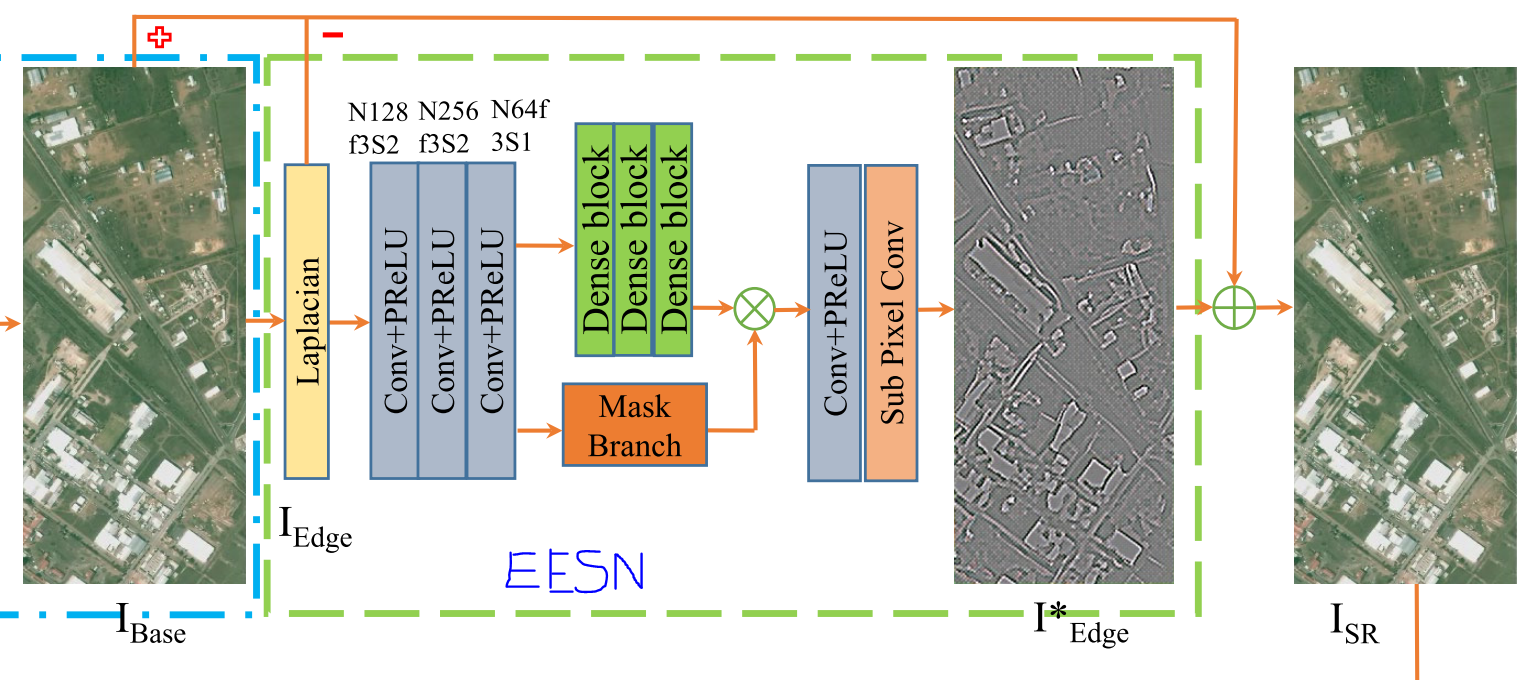

In [10]:
#building eesn model
def build_eesn(Ibase_shape):
  inp=Input(shape=(Ibase_shape))
  bw=Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_initializer=meanfilter)(inp)  #taking mean of the Ibase batch to get gray-scale image
  Iedge=Conv2D(filters=1, kernel_size=(3,3), padding='same', kernel_initializer=laplacian, trainable=False)(bw)     #taking laplacian of the image
  Itrip=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Iedge)   #triplicating brfore addition
  
  sub=Subtract()([inp, Itrip])  #removing distorted edges
  ee=Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(2,2))(Iedge)
  ee=Conv2D(filters=256, kernel_size=(3,3), padding='same')(ee)
  ee=Conv2D(filters=64, kernel_size=(1,1), padding='same')(ee)
  
  #dense net
  db=dense_block(ee)
  db=dense_block(db)
  db=dense_block(db)
  db=Conv2D(56, kernel_size=(3,3), padding='same')(db)

  #mask branch
  mb=Conv2D(filters=64, kernel_size=(3,3), padding='same')(ee)
  mb=LeakyReLU(alpha=0.2)(mb)
  mb=Conv2D(filters=128, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.2)(mb)
  mb=Conv2D(filters=56, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.2)(mb)
  mb=Activation('sigmoid')(mb)

  ee=Conv2D(4, kernel_size=(3,3), padding='same')(Multiply()([mb, db]))
  Istedge=SubpixelConv2D(ee.shape, scale=2)(ee)   #upscaling with efficient subpixel convolution
  Istedge=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Istedge)  #triplicating to substract
  SR=Add()([Istedge, sub])
  model=Model(inputs=inp, outputs=SR)  #binding the layers as a single eesn model
  return model

Please run the next shells to create our EESN model and view its plot and structure

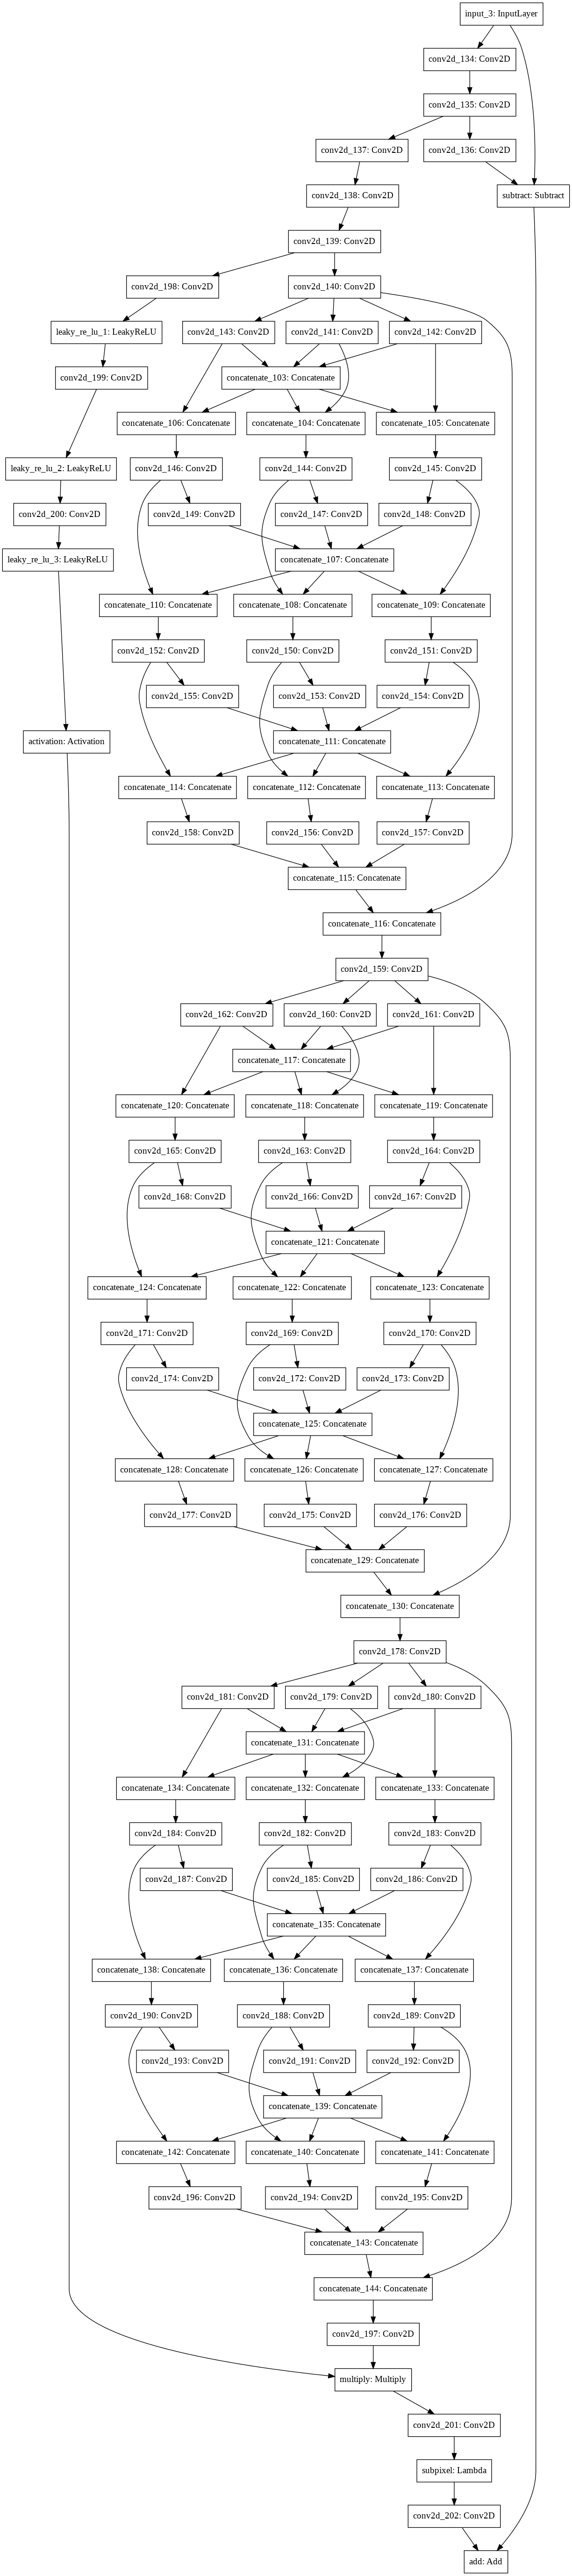

In [11]:
eesn=build_eesn(Ibase_shape=(256,256,3))
plot_model(eesn)

In [12]:
eesn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 256, 256, 1)  4           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 256, 1)  10          conv2d_134[0][0]                 
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, 128, 128, 128 1280        conv2d_135[0][0]                 
____________________________________________________________________________________________

Here, our generator is ready with the udsn and eesn models.
Now we move to the discriminator.

#Discriminator
As was given in our paper, we used the same discriminator model of PRGAN.
Its structure is shown below

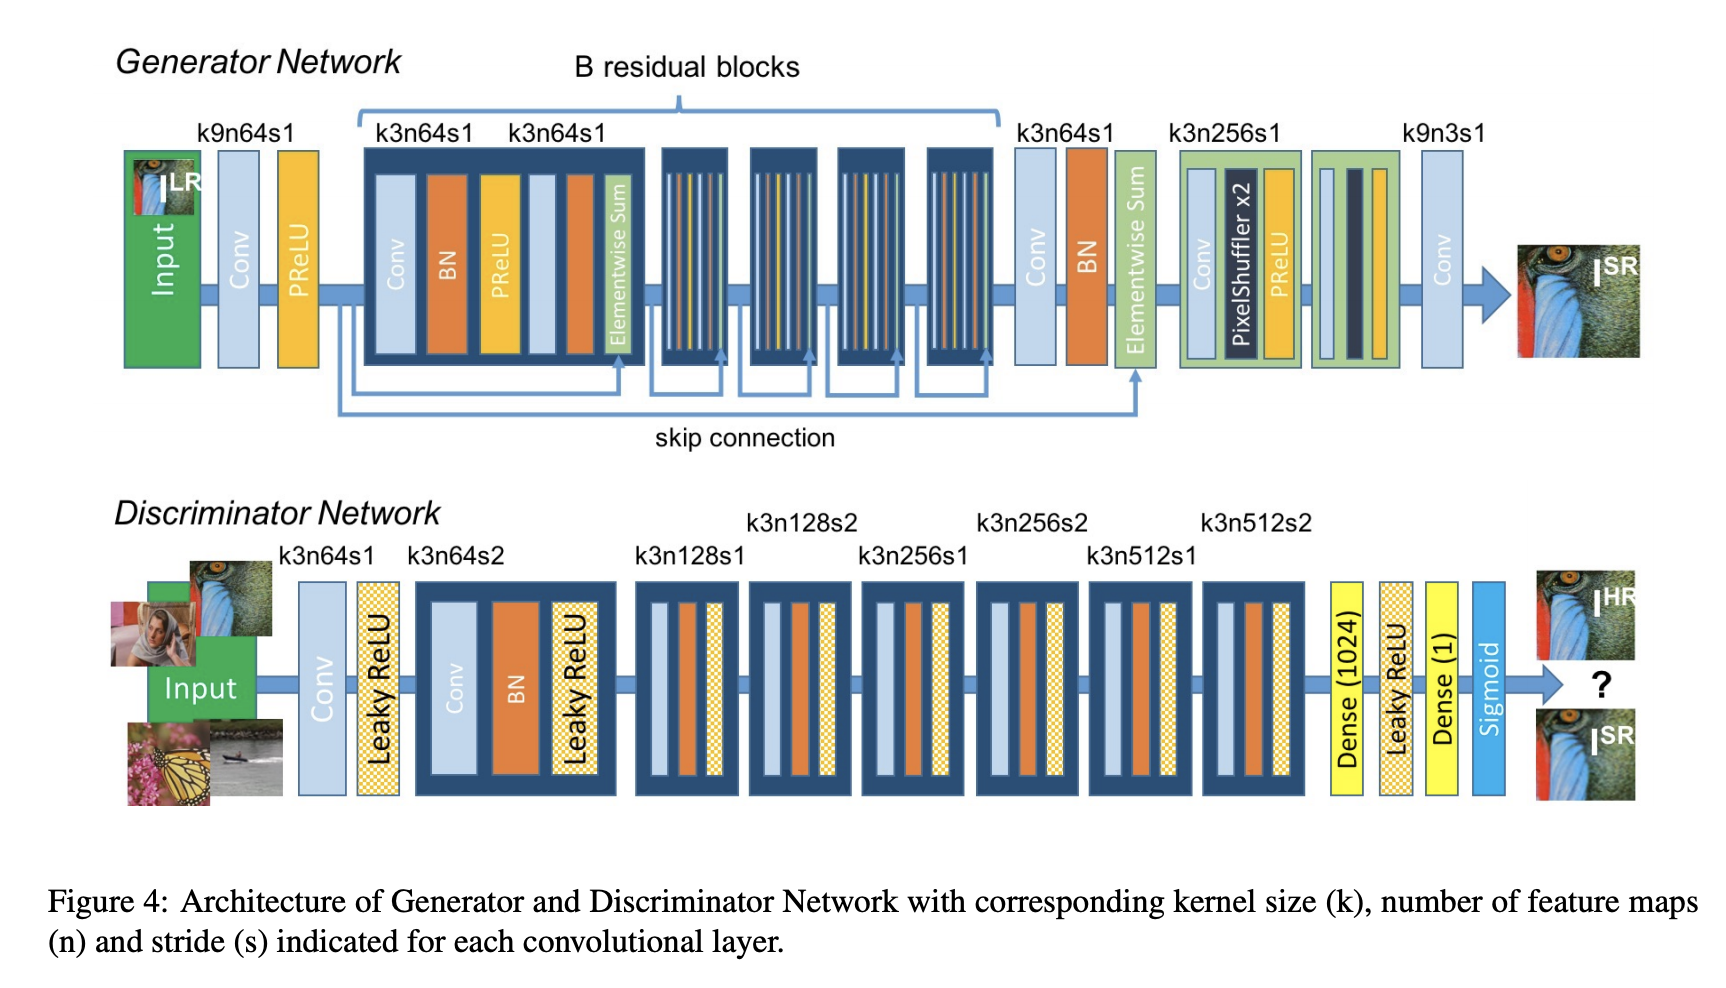

In [13]:
def build_discriminator(img_shape):
  def block(Input, k, n, s):
    l1=Conv2D(n, kernel_size=(k,k), strides=(s,s), padding='same')(Input)
    Bn=BatchNormalization()(l1)
    Lrlu=LeakyReLU(alpha=0.2)(Bn)
    return Lrlu
  I1=Input(shape=img_shape)
  c1=Conv2D(64, kernel_size=(3,3), padding='same')(I1)
  l1=LeakyReLU(alpha=0.2)(c1)
  b1=block(l1, 3, 64, 2)
  b2=block(b1, 3, 128, 1)
  b3=block(b2, 3, 128,2)
  b4=block(b3, 3, 256, 1)
  b5=block(b4, 3, 256, 2)
  b6=block(b5, 3, 512, 1)
  b7=block(b6, 3, 512, 2)
  b8=Flatten()(b7)
  b9=Dropout(.5)(b8)
  l8=Dense(1024)(b9)
  b10=Dropout(.25)(l8)
  l9=LeakyReLU(alpha=0.2)(b10)
  l10=Dense(1, activation='sigmoid')(l9)
  m=Model(inputs=I1, outputs=l10)
  opt=Adam(learning_rate=0.002, beta_1=0.5)
  m.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return m

Please run the shell to build a generator and view its structure

In [14]:
disc=build_discriminator(img_shape=(256,256,3))
disc.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 128, 128, 128)     7385

Let's take a moment to load the dataset.
Please run the shell below to download the dataset into colab server. 

250249216/250242400 [==============================] - 57s 0us/step


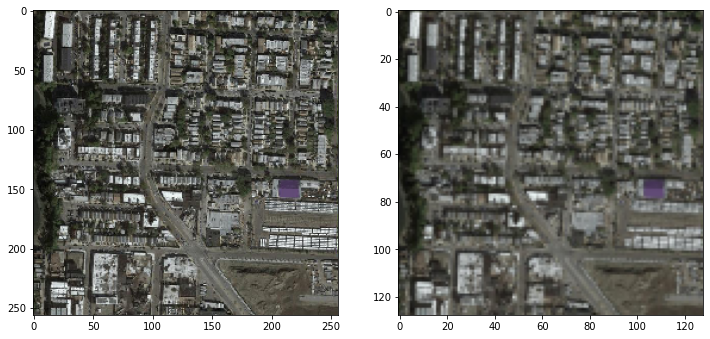

In [15]:
import os
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.io import read_file
from skimage import data, color
from skimage.transform import resize
url='http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz'
path_to_zip=get_file('maps.tar.gz', origin=url, extract=True)
inside_train=listdir('/root/.keras/datasets/maps/train')
src_list=[]
full_path='/root/.keras/datasets/maps/train/'
for filename in inside_train:
  pixels=load_img(full_path+filename, target_size=(256,512))
  pixels=img_to_array(pixels)
  src_list.append(pixels[:,:256])
src_list=np.asarray(src_list)
resized_list=[]
for i in src_list:
  image=i
  image_resized = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
                        anti_aliasing=True)
  resized_list.append(image_resized)
resized_list=np.array(resized_list)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(src_list[0].astype('uint8'))
plt.title('IHR')
plt.subplot(1,2,2)
plt.imshow(resized_list[0].astype('uint8'))
plt.title('ILR')

We move to the next part 


#Training
As described in the paper, training of this generator was facilitated with tree loss functions. The **Charbonnier penalty**, the **Consistency loss** and the **Adversarial loss** calculated via discriminator.

For the Adversarial loss, we have used our discriminator successfully. But for the Charbonnier penalty on Ibase and Consistency loss on ISR, we have made two new models just for training the udsn and eesn accordingly.

##Charbonnier penalty
We construct a robust
content loss function to enforce the generator G to generate a
intermediate HR image IBase similar to IHR using the following
model:

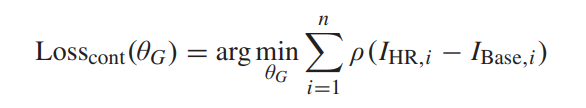

where θG denotes a set of model parameters in G, and
ρ(x) = (x 2 + ε2)
(1/2) represents the Charbonnier penalty
function [33]. We empirically set the compensation parameter
ε of 10−3. IBase,i and IHR,i refer to the extracted features of
the reconstructed image and the ground truth by VGG-net,
respectively. 
So first import the vgg16 network. Please run the shell below.

In [17]:
from keras.applications.vgg16 import VGG16
vgg=VGG16()
vgg.trainable=False
resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=RandomNormal(stddev=0.2), trainable=False)

553467904/553467096 [==============================] - 4s 0us/step


The resize-layer is added to resize the input image to vgg16 input requirement (224, 224, 3). Note that both of these (vgg and resize_layer) are made non-trainable.

Now creating a charbonnier penalty function and building one trainable model. Please run the shell below.

In [18]:
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean((y_true-y_pred)**2 + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  resize_Ibase=resize_layer(Ibase) #adjusting size before input to vgg-net
  out=vgg(resize_Ibase)  #extracted features
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.002, beta_1=0.5)
  model.compile(loss=charbonnier_penalty, optimizer=opt, metrics=['accuracy'])
  return model

Note that in the charbonnier model we take in the LR images batch and predict the corresponding Ibase images batch which is then passed to vgg-net to extract its features.

In [19]:
charb=charbonnier_model(img_shape=(128,128,3))
charb.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_1 (Functional)         (None, 256, 256, 3)       5861196   
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 224, 224, 3)       9804      
_________________________________________________________________
vgg16 (Functional)           (None, 1000)              138357544 
Total params: 144,228,544
Trainable params: 5,861,196
Non-trainable params: 138,367,348
_________________________________________________________________


For training with this model, we will take the HR images batch and pass it through vgg-net to extract the ground truth features. The charb model output tensor and the ground truth tensor will be used to train our generator upon charbonnier penalty.
Please run the shell below.

In [20]:
def train_charbonnier_model(input_batch, HR_batch):
  
  #extracting HR Image features through VGG
  HR_resized=resize_layer(HR_batch)
  ground_feat=vgg(HR_resized)

  loss, acc=charb.train_on_batch(input_batch, ground_feat)
  return loss, acc

##Consistency Loss
It is well known that adversarial learning strategies can
maintain the visual authenticity of the generated images but
with a large number of artifacts and indeterminate details.
In order to improve the quality of reconstructed image and
reduce artifacts, we further introduce the pixel-based Charbonnier loss to enhance the consistency of image contents between
ISR and IHR. The consistency loss function is formulated as
follows:

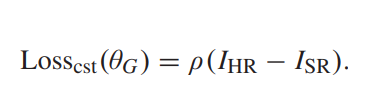

where θG denotes the model parameters in G. ISR and IHR
refer to the final SR output and the ground truth, respectively.
Please run the shell below to define the consistency loss and concisistency loss model.

In [21]:
def consistency_loss(y_true, y_pred):
  lambd=5
  return 5*charbonnier_penalty(y_true, y_pred)

def consistency_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  model=Model(inputs=inp, outputs=ISR)
  opt=Adam(learning_rate=0.002, beta_1=0.5)
  model.compile(loss=consistency_loss, optimizer=opt, metrics=['accuracy'])
  return model

In [22]:
#building a consistency loss model
cons_model=consistency_model(img_shape=(128,128,3))
cons_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_1 (Functional)         (None, 256, 256, 3)       5861196   
_________________________________________________________________
model_2 (Functional)         (None, 256, 256, 3)       2392494   
Total params: 8,253,690
Trainable params: 8,253,668
Non-trainable params: 22
_________________________________________________________________


training the eesn via consistency loss occurs directly on ISR and IHR image batches passed onto consistency_loss function.
Please run the shell below

In [23]:
def train_consistency_model(input_batch, HR_batch):
  loss, acc=cons_model.train_on_batch(input_batch, HR_batch)
  return loss, acc

##Adversarial loss
Training the genertor on adversarial loss uses both the discriminator and generator simultaneously in a zero-sum fashion.
The model used for training these two models is termed GAN.

Our GAN consists of the generator(udsn + eesn) and the discriminator(disc). As suggested in the paper. udsn is first fed with ILR batch to generate Ibase batch. The Ibase batch is then fed into the eesn model to restore the high-frequency distorted edges and produce ISR batch. This ISR batch is fed into the discriminator to output the 0/1 batch results.

Please run the cell below to define our GAN model.

In [24]:
def build_gan(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  out=disc(ISR)
  disc.trainable=False
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [25]:
#building a GAN
gan=build_gan(img_shape=(128,128,3))
gan.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_1 (Functional)         (None, 256, 256, 3)       5861196   
_________________________________________________________________
model_2 (Functional)         (None, 256, 256, 3)       2392494   
_________________________________________________________________
model_3 (Functional)         (None, 1)                 138912577 
Total params: 147,166,267
Trainable params: 8,253,668
Non-trainable params: 138,912,599
_________________________________________________________________


###GAN Taining
GAN training in itself is a very interesting concept. Its like a zero-sum game where first the discriminator is trained with real images to output '1' (identifying real). Then the discriminator is trained on fake images(coming from the generator) to output '0' (false indentification). This was the only time discriminator was trainable.

Now we train the generator via the gan model. In this process, we feed the gan with LR image batch to output '1'(false negatives). And in this process the discriminator remains untrainable(Note it was made untrainable while defining gan).


> GAN generally has untrainable discriminator or slow training generator.

However we will first prepare two functions to output input-output pairs for real and fake training of the generator.
Please run the shell below.





In [26]:
def generate_real_samples(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  HR_batch=src_list[ix]
  y_real=np.ones(shape=(n_batch,))
  return HR_batch, y_real

def generate_fake_samples(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  LR_batch=resized_list[ix]
  HR_batch_fake=eesn(udsn(LR_batch))
  y_fake=np.zeros(shape=(n_batch,))
  return HR_batch_fake, y_fake

Note for generating real samples, we are using the HR batch, while for generating the fake labels we are using the SR batch output of generator after LR batch input.

Now we move to training all our models. We take in the number of epochs and batch size as input.
In each epoch, we take some LR images and corresponding HR images. 
The udsn and eesn were trained via charbonnier and consistency loss models.
And then we move to train the discriminator for the batch of real samples and fake samples. The batch size is halved because we train the model twice.
Next the gan model is trained to train the generator via the discriminator.

Run the code next to define our training procedure

In [27]:
def train(n_epochs=20, n_batch=2):
  half_batch=n_batch//2
  for i in range(n_batch):
    ix=np.random.randint(0, 1096, n_batch)
    LR_batch=resized_list[ix]
    HR_batch=src_list[ix]
    
    charb_loss, charb_acc=train_charbonnier_model(LR_batch, HR_batch)
    cons_loss, cons_acc=train_consistency_model(LR_batch, HR_batch)

    real_batch, y_real=generate_real_samples(half_batch)
    fake_batch, y_fake=generate_fake_samples(half_batch)

    disc_loss_real, disc_acc_real=disc.train_on_batch(real_batch, y_real)
    disc_loss_fake, disc_acc_fake=disc.train_on_batch(fake_batch, y_fake)

    false_negatives=np.ones(shape=(n_batch,))
    gan_loss, gan_acc= gan.train_on_batch(LR_batch, false_negatives)

    print('%d charb_loss[%.6f] cons_loss[%.6f] disc_loss_real[%.6f] disc_loss_fake[%.6f] gan_loss[%.6f]'%(i+1, charb_loss, cons_loss, disc_loss_real, 
                                                                                                          disc_loss_fake, gan_loss))

You may run the code next to see the process work, but its not recommended as it is taking much time now on a colab server.

In [ ]:
#train(2, 2)

###View the results
Run the code below to view the resluts throughout the generator model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'IHR')

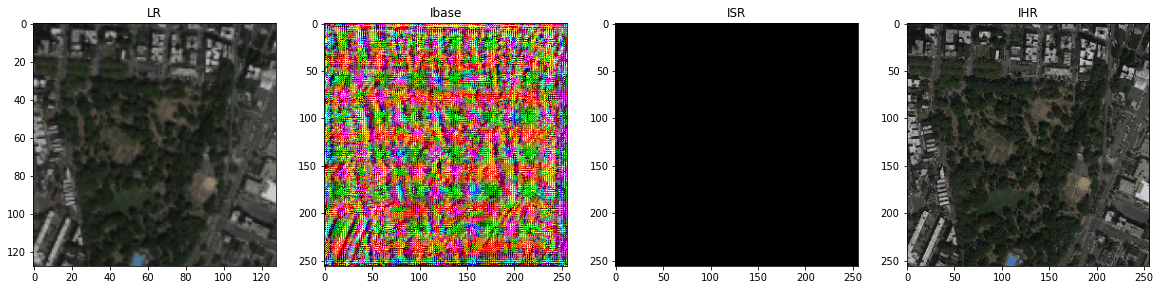

In [28]:
ix=np.random.randint(0, 1096, 1)
ILR=resized_list[ix]
IHR=src_list[ix]
Ibase=udsn(ILR)
ISR=eesn(Ibase)
plt.figure(figsize=(20,80))

plt.subplot(1,4,1)
plt.imshow(ILR.reshape(128,128,3).astype('uint8'))
plt.title('LR')

plt.subplot(1,4,2)
plt.imshow(Ibase[0])
plt.title('Ibase')

plt.subplot(1,4,3)
plt.imshow(ISR[0])
plt.title('ISR')

plt.subplot(1,4,4)
plt.imshow(IHR.reshape(256,256,3).astype('uint8'))
plt.title('IHR')

###with respect,
Ayush Nath Jha(1804118)

Tushar Ranjan(1804123)

Shivendra pratap singh(1804122)